# Part 1 — Time Series Analysis (Foodstuff CPI)

**Mục tiêu:**  
- Phân tích chuỗi thời gian của `Foodstuff_toDecCPI` (Foodstuff CPI) và `CPI_rate`.  
- Kiểm tra xu hướng, seasonality, ACF/PACF, stationarity (ADF/KPSS).  
- Xác định p,d,q cho ARIMA, lựa chọn mô hình bằng AIC/BIC.  
- Dự báo trên tập kiểm tra, đánh giá RMSE/MAE.  
- Residual diagnostics (Ljung-Box).  
- Tìm kiếm SARIMA mùa (m=12).  
- So sánh với phương pháp Machine Learning (ví dụ RandomForest trên lag-features).  
- Đảm bảo reproducibility (seed)


In [1]:

import warnings
warnings.filterwarnings("ignore")

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit

random.seed(42)
np.random.seed(42)


In [38]:

# Load dataset
fn = "TSA_DATA\Data01_02_FoodstuffCPI.csv"
df = pd.read_csv(fn)

# convert Year+Month to datetime (first day of month)
if 'Date' not in df.columns:
    df['Date'] = pd.to_datetime(dict(year=df['Year'], month=df['Month'], day=1))
df = df.set_index('Date').sort_index()

# quick check
print("Shape:", df.shape)
print(df.columns.tolist())
df.head(8)


Shape: (96, 6)
['Time', 'Year', 'Month', 'Foodstuff_toDecCPI', 'CPI_toPM', 'CPI_rate']


,Time,Year,Month,Foodstuff_toDecCPI,CPI_toPM,CPI_rate
Date,,,,,,
2015-01-01,1,2015,1,100.5,100.500000,0.500000
2015-02-01,2,2015,2,100.7,100.199005,0.199005
2015-03-01,3,2015,3,100.5,99.801390,-0.198610
2015-04-01,4,2015,4,99.3,98.805970,-1.194030
2015-05-01,5,2015,5,99.5,100.201410,0.201410
2015-06-01,6,2015,6,99.3,99.798995,-0.201005
2015-07-01,7,2015,7,100.3,101.007049,1.007049
2015-08-01,8,2015,8,100.6,100.299103,0.299103


## Data description

- File: `Data01_02_FoodstuffCPI.csv`  
- Các cột chính: `Time`, `Year`, `Month`, `Foodstuff_toDecCPI`, `CPI_toPM`, `CPI_rate`.  
- `Foodstuff_toDecCPI` được coi là **Series 1** (Foodstuff CPI).  
- `CPI_rate` được coi là **Series 3** (CPI rate).  

(Tại đây ghi chú nguồn dữ liệu, dải thời gian, tần suất (monthly) và bất kỳ missing values nào.)


In [39]:
# summary stats
display(df[['Foodstuff_toDecCPI','CPI_rate','CPI_toPM']].describe().T)

# missing values
print("\nMissing values per column:")
print(df.isna().sum())


,count,mean,std,min,25%,50%,75%,max
Foodstuff_toDecCPI,96.0,100.292292,1.221225,97.650000,99.500000,100.180000,100.870000,103.400000
CPI_rate,96.0,0.017834,1.498983,-4.162633,-0.635031,0.048403,0.724662,2.991027
CPI_toPM,96.0,100.017834,1.498983,95.837367,99.364969,100.048403,100.724662,102.991027



Missing values per column:
Time                  0
Year                  0
Month                 0
Foodstuff_toDecCPI    0
CPI_toPM              0
CPI_rate              0
dtype: int64


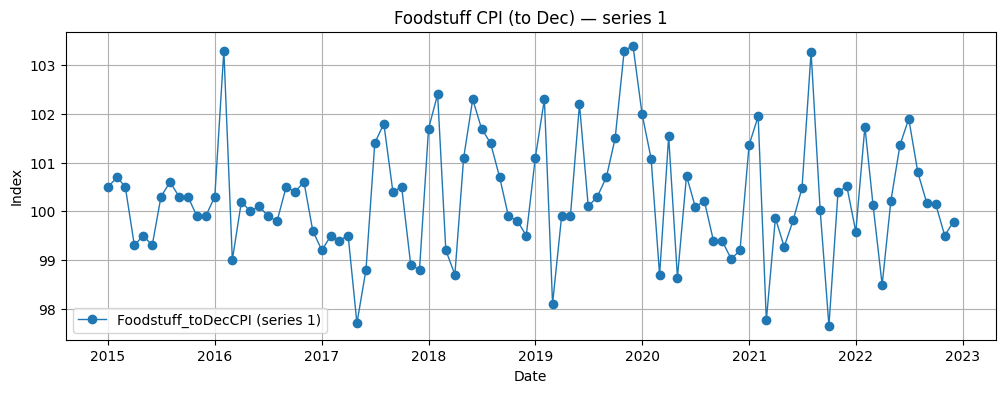

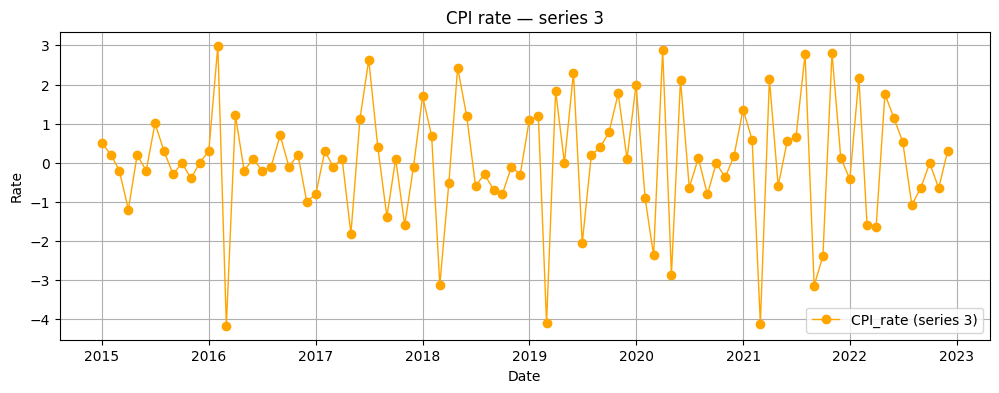

In [5]:
ts1 = df['Foodstuff_toDecCPI'].astype(float)
ts3 = df['CPI_rate'].astype(float)

plt.figure(figsize=(12,4))
plt.plot(ts1, marker='o', linewidth=1, label='Foodstuff_toDecCPI (series 1)')
plt.title('Foodstuff CPI (to Dec) — series 1')
plt.ylabel('Index')
plt.xlabel('Date')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(ts3, marker='o', linewidth=1, label='CPI_rate (series 3)', color='orange')
plt.title('CPI rate — series 3')
plt.ylabel('Rate')
plt.xlabel('Date')
plt.grid(True)
plt.legend()
plt.show()


## Trend checking
- Sử dụng rolling mean (window = 12) và seasonal_decompose nếu cần.
- Mục tiêu: quan sát trend và seasonal component.


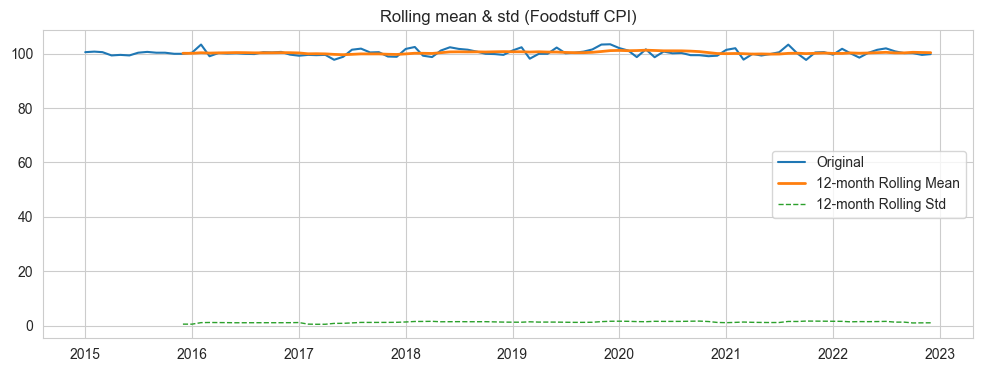

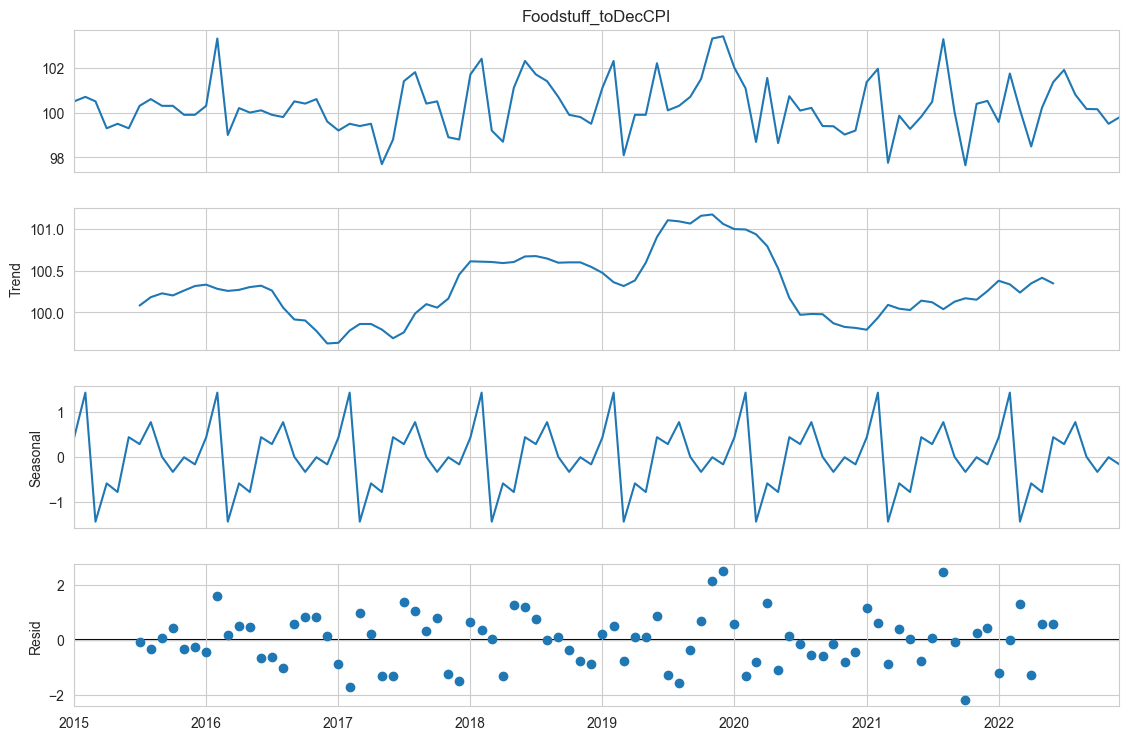

In [40]:
# rolling mean (12-month) for monthly data
plt.figure(figsize=(12,4))
plt.plot(ts1, label='Original')
plt.plot(ts1.rolling(window=12).mean(), label='12-month Rolling Mean', linewidth=2)
plt.plot(ts1.rolling(window=12).std(), label='12-month Rolling Std', linewidth=1, linestyle='--')
plt.title('Rolling mean & std (Foodstuff CPI)')
plt.legend(); plt.show()

# seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
try:
    decomposition = seasonal_decompose(ts1.dropna(), model='additive', period=12)
    fig = decomposition.plot()
    fig.set_size_inches(12,8)
    plt.show()
except Exception as e:
    print("Decompose error (maybe short series):", e)


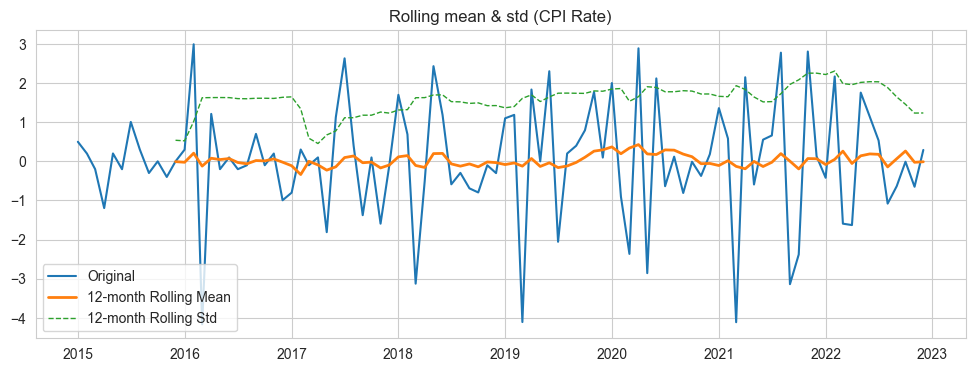

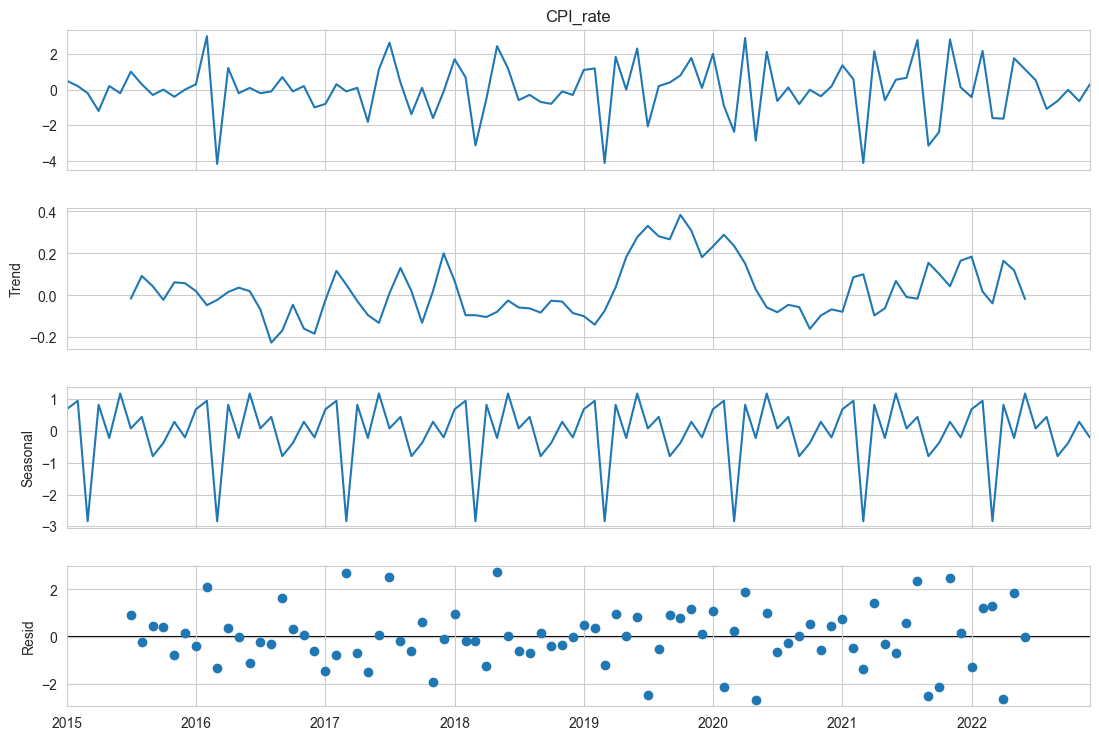

In [42]:
# rolling mean (12-month) for monthly data
plt.figure(figsize=(12,4))
plt.plot(ts3, label='Original')
plt.plot(ts3.rolling(window=12).mean(), label='12-month Rolling Mean', linewidth=2)
plt.plot(ts3.rolling(window=12).std(), label='12-month Rolling Std', linewidth=1, linestyle='--')
plt.title('Rolling mean & std (CPI Rate)')
plt.legend(); plt.show()

# seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
try:
    decomposition = seasonal_decompose(ts3.dropna(), model='additive', period=12)
    fig = decomposition.plot()
    fig.set_size_inches(12,8)
    plt.show()
except Exception as e:
    print("Decompose error (maybe short series):", e)


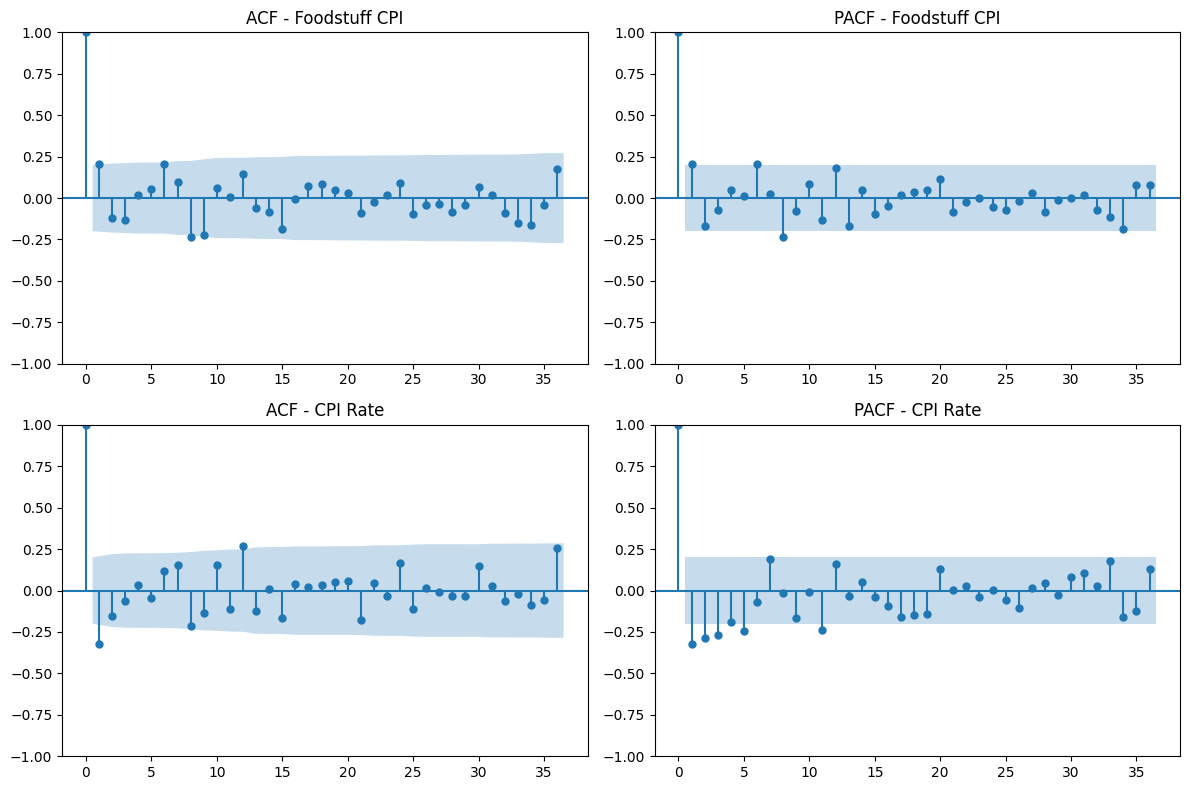

In [7]:
plt.figure(figsize=(12,8))
ax1 = plt.subplot(221)
plot_acf(ts1.dropna(), ax=ax1, lags=36)
ax1.set_title('ACF - Foodstuff CPI')
ax2 = plt.subplot(222)
plot_pacf(ts1.dropna(), ax=ax2, lags=36, method='ywm')
ax2.set_title('PACF - Foodstuff CPI')
ax3 = plt.subplot(223)
plot_acf(ts3.dropna(), ax=ax3, lags=36)
ax3.set_title('ACF - CPI Rate')
ax4 = plt.subplot(224)
plot_pacf(ts3.dropna(), ax=ax4, lags=36, method='ywm')
ax4.set_title('PACF - CPI Rate')
plt.tight_layout(); plt.show()


## Autocorrelation Function (ACF)

**Mục tiêu:**  
- Kiểm tra mức độ tương quan tuyến tính giữa giá trị hiện tại và các độ trễ (lag) trong chuỗi thời gian.  
- Giúp xác định giá trị thích hợp của **q** trong mô hình ARIMA(p,d,q).  

**Diễn giải:**  
- Nếu ACF giảm dần từ từ → chuỗi có thể chưa dừng.  
- Nếu ACF cắt ngang (cut-off) sau một vài lag → chuỗi có thể dừng.  
- Các spike vượt ngưỡng tin cậy (vạch xanh) thể hiện mối tương quan có ý nghĩa thống kê.


<Figure size 1000x400 with 0 Axes>

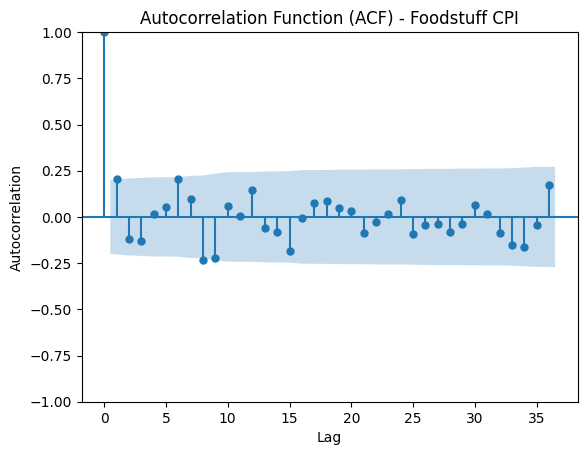

<Figure size 1000x400 with 0 Axes>

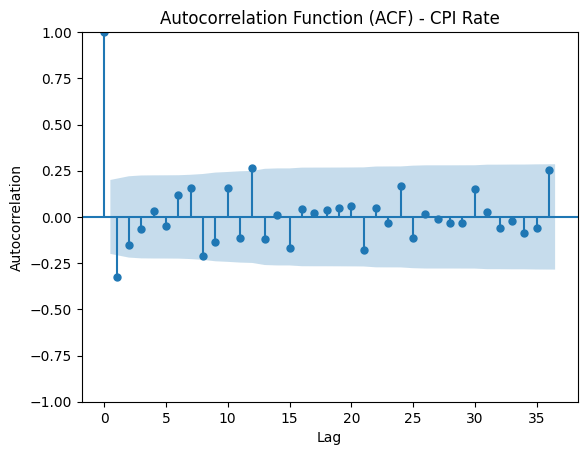

In [18]:
# Autocorrelation Function (ACF)
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(10,4))
plot_acf(ts1.dropna(), lags=36)
plt.title('Autocorrelation Function (ACF) - Foodstuff CPI')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

plt.figure(figsize=(10,4))
plot_acf(ts3.dropna(), lags=36)
plt.title('Autocorrelation Function (ACF) - CPI Rate')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()


## Partial Autocorrelation Function (PACF)

**Mục tiêu:**  
- Đo lường mức độ tương quan của chuỗi với các giá trị trễ **sau khi loại bỏ ảnh hưởng trung gian của các độ trễ khác**.  
- Giúp xác định giá trị thích hợp của **p** trong mô hình ARIMA(p,d,q).  

**Diễn giải:**  
- Nếu PACF cắt ngang sau một vài lag → đó là dấu hiệu cho phần AR(p).  
- Nếu PACF giảm dần từ từ → chuỗi có thể chứa phần MA(q).


<Figure size 1000x400 with 0 Axes>

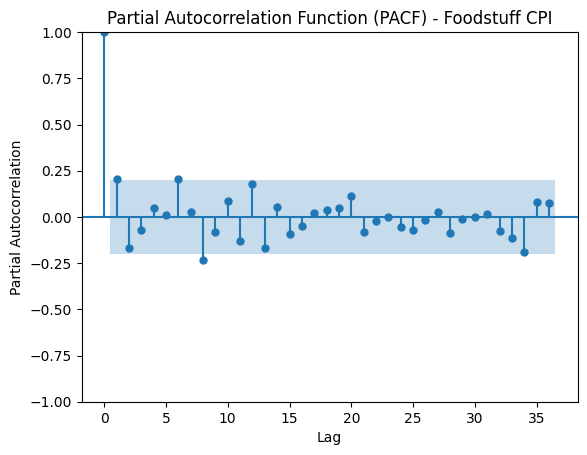

<Figure size 1000x400 with 0 Axes>

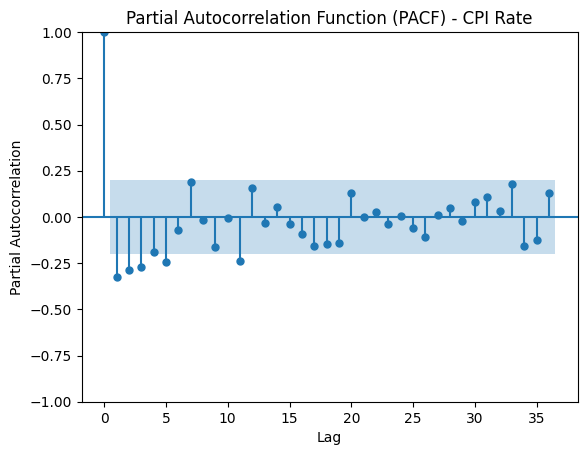

In [19]:
# Partial Autocorrelation Function (PACF)
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(10,4))
plot_pacf(ts1.dropna(), lags=36, method='ywm')
plt.title('Partial Autocorrelation Function (PACF) - Foodstuff CPI')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

plt.figure(figsize=(10,4))
plot_pacf(ts3.dropna(), lags=36, method='ywm')
plt.title('Partial Autocorrelation Function (PACF) - CPI Rate')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()


## Stationarity tests
- Chạy ADF (Augmented Dickey-Fuller) và KPSS cho mỗi series.
- Giải thích: nếu ADF p-value < 0.05 → reject null (stationary). KPSS p-value < 0.05 → reject null (trend stationary null).


In [8]:
def adf_test(series, title='Series'):
    print(f'--- ADF test for {title} ---')
    res = adfuller(series.dropna(), autolag='AIC')
    print(f'ADF Statistic: {res[0]:.4f}')
    print(f'p-value: {res[1]:.4f}')
    print('Used lag:', res[2])
    print('Number of obs used:', res[3])
    print('Critical values:')
    for k,v in res[4].items():
        print(f'   {k}: {v:.4f}')
    if res[1] < 0.05:
        print("Conclusion: Reject H0 → stationary")
    else:
        print("Conclusion: Fail to reject H0 → non-stationary")
    print()

def kpss_test(series, title='Series'):
    print(f'--- KPSS test for {title} ---')
    try:
        res = kpss(series.dropna(), regression='c', nlags="auto")
        print(f'KPSS Statistic: {res[0]:.4f}')
        print(f'p-value: {res[1]:.4f}')
        print('Critical values:')
        for k,v in res[3].items():
            print(f'   {k}: {v:.4f}')
        if res[1] < 0.05:
            print("Conclusion: Reject H0 → data is not stationary")
        else:
            print("Conclusion: Fail to reject H0 → data is stationary")
    except Exception as e:
        print("KPSS failed:", e)
    print()

adf_test(ts1, "Foodstuff CPI")
kpss_test(ts1, "Foodstuff CPI")
adf_test(ts3, "CPI rate")
kpss_test(ts3, "CPI rate")


--- ADF test for Foodstuff CPI ---
ADF Statistic: -7.1048
p-value: 0.0000
Used lag: 1
Number of obs used: 94
Critical values:
   1%: -3.5019
   5%: -2.8928
   10%: -2.5835
Conclusion: Reject H0 → stationary

--- KPSS test for Foodstuff CPI ---
KPSS Statistic: 0.1209
p-value: 0.1000
Critical values:
   10%: 0.3470
   5%: 0.4630
   2.5%: 0.5740
   1%: 0.7390
Conclusion: Fail to reject H0 → data is stationary

--- ADF test for CPI rate ---
ADF Statistic: -7.6650
p-value: 0.0000
Used lag: 4
Number of obs used: 91
Critical values:
   1%: -3.5043
   5%: -2.8939
   10%: -2.5840
Conclusion: Reject H0 → stationary

--- KPSS test for CPI rate ---
KPSS Statistic: 0.2638
p-value: 0.1000
Critical values:
   10%: 0.3470
   5%: 0.4630
   2.5%: 0.5740
   1%: 0.7390
Conclusion: Fail to reject H0 → data is stationary



C:\Users\ADMIN\AppData\Local\Temp\ipykernel_29872\4263812577.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  res = kpss(series.dropna(), regression='c', nlags="auto")
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_29872\4263812577.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  res = kpss(series.dropna(), regression='c', nlags="auto")


# 1.3 — Determine parameters p, q, d and 1.4–1.7 ARIMA/SARIMA modelling & ML workflow

This section automates:
- determine max p and q from PACF/ACF respectively,
- determine d from stationarity tests (ADF/KPSS),
- grid-search ARIMA(p,d,q) and select by AIC + parameter stability (CI not containing zero),
- forecast mean values on holdout and compute RMSE/MAE,
- ML-style iterative search for best ARIMA by RMSE,
- SARIMA seasonal grid search over (P, D=0, Q, m=12) with RMSE selection.

Applied to:
- Series 1: `Foodstuff_toDecCPI`
- Series 3: `CPI_rate`


In [23]:
# Imports (run at top of notebook if not done)
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

sns.set_style("whitegrid")


In [21]:
# Update path if needed
df = pd.read_csv("TSA_DATA\Data01_02_FoodstuffCPI.csv")
# build datetime index if not yet
if 'Date' not in df.columns:
    df['Date'] = pd.to_datetime(dict(year=df['Year'], month=df['Month'], day=1))
df = df.set_index('Date').sort_index()

# series names
series_map = {
    'series1': 'Foodstuff_toDecCPI',
    'series3': 'CPI_rate'
}

ts1 = df[series_map['series1']].astype(float)
ts3 = df[series_map['series3']].astype(float)
series_dict = {'series1': ts1, 'series3': ts3}


series1: suggested p_max=8, q_max=9, conf_limit=0.2000


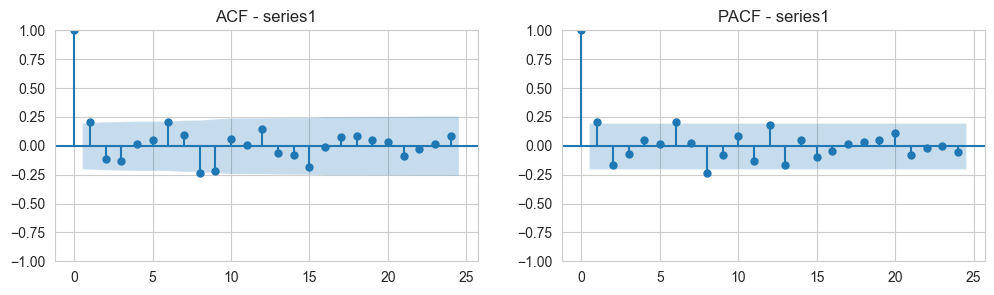

series3: suggested p_max=11, q_max=12, conf_limit=0.2000


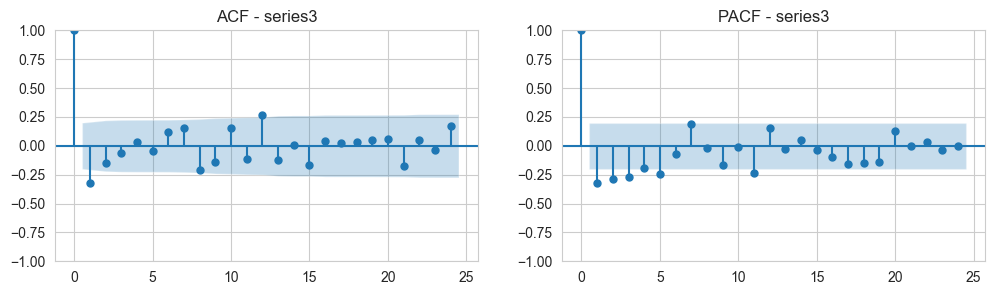

In [24]:
def detect_max_p_q(series, nlags=24, alpha=0.05):
    """
    Determine maximum p from PACF and maximum q from ACF.
    Heuristic: find the last lag where pacf/acf exceeds significance bounds.
    Returns: p_max, q_max, acf_vals, pacf_vals, conf_limit
    """
    s = series.dropna()
    n = len(s)
    if n < 10:
        return 0, 0, None, None, None

    # compute acf and pacf
    acf_vals = acf(s, nlags=nlags, fft=False)
    pacf_vals = pacf(s, nlags=nlags, method='ywm')  # ywm is robust

    # significance approx: +-1.96/sqrt(n)
    conf = 1.96 / np.sqrt(n)

    # determine last lag where pacf > conf -> p_max
    p_max = 0
    for lag in range(1, nlags+1):
        if abs(pacf_vals[lag]) > conf:
            p_max = lag

    # determine last lag where acf > conf -> q_max
    q_max = 0
    for lag in range(1, nlags+1):
        if abs(acf_vals[lag]) > conf:
            q_max = lag

    return p_max, q_max, acf_vals, pacf_vals, conf

# Example quick print for both series
for key, s in series_dict.items():
    p_max, q_max, a_vals, p_vals, conf = detect_max_p_q(s, nlags=24)
    print(f"{key}: suggested p_max={p_max}, q_max={q_max}, conf_limit={conf:.4f}")
    # optional quick plot
    fig, ax = plt.subplots(1,2,figsize=(12,3))
    plot_acf(s.dropna(), ax=ax[0], lags=24)
    plot_pacf(s.dropna(), ax=ax[1], lags=24, method='ywm')
    ax[0].set_title(f"ACF - {key}"); ax[1].set_title(f"PACF - {key}")
    plt.show()


In [26]:
def run_adf(series):
    s = series.dropna()
    res = adfuller(s, autolag='AIC')
    return {'adf_stat': res[0], 'pvalue': res[1], 'used_lag': res[2], 'nobs': res[3], 'crit': res[4]}

def run_kpss(series):
    try:
        res = kpss(series.dropna(), regression='c', nlags='auto')
        return {'kpss_stat': res[0], 'pvalue': res[1], 'crit': res[3]}
    except Exception as e:
        return {'kpss_stat': None, 'pvalue': None, 'crit': None, 'error': str(e)}

stationarity = {}
for key, s in series_dict.items():
    adf_res = run_adf(s)
    kpss_res = run_kpss(s)
    # d decision: if ADF pvalue < 0.05 -> stationary -> d=0 else d=1
    d = 0 if adf_res['pvalue'] < 0.05 else 1
    stationarity[key] = {'adf': adf_res, 'kpss': kpss_res, 'd': d}
    print(f"{key}: ADF p={adf_res['pvalue']:.4f} → d={d} (KPSS p={kpss_res.get('pvalue')})")


series1: ADF p=0.0000 → d=0 (KPSS p=0.1)
series3: ADF p=0.0000 → d=0 (KPSS p=0.1)


### Determined maximum p and q (from PACF/ACF) and d (from ADF)
- For each series we will use p_max and q_max from the detector above as upper bounds to grid search.
- The automatic d chosen from the ADF test will be used (0 or 1).  
Record these values in the notebook before proceeding to grid search.


In [27]:
import warnings
warnings.filterwarnings("ignore")

def arima_grid_search(series, p_max, d_vals, q_max, seasonal=False, seasonal_order=None, maxiter=50):
    """
    Grid search ARIMA over p in [0..p_max], d in d_vals, q in [0..q_max].
    For each model, fits ARIMA(series, order=(p,d,q)), records AIC, BIC and param CIs.
    Returns dataframe sorted by AIC and a dict of fitted results for top models.
    """
    s = series.dropna()
    results = []
    fitted_models = {}
    for d in d_vals:
        for p in range(0, p_max+1):
            for q in range(0, q_max+1):
                order = (p,d,q)
                try:
                    if seasonal and seasonal_order:
                        mod = SARIMAX(s, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
                        res = mod.fit(disp=False, maxiter=maxiter)
                    else:
                        mod = ARIMA(s, order=order)
                        res = mod.fit()
                    aic = res.aic
                    bic = res.bic
                    # compute confidence intervals
                    try:
                        ci = res.conf_int()
                        # stable if none intervals include zero? choose this criterion
                        # check that for all params, both bounds are finite and do not include zero
                        stable = True
                        for row in ci.values:
                            if np.isnan(row).any():
                                stable = False
                                break
                            if row[0] <= 0 <= row[1]:
                                stable = False
                                break
                    except Exception:
                        ci = None
                        stable = False
                    results.append({'order': order, 'aic': aic, 'bic': bic, 'stable_params': stable})
                    # keep model for possible re-evaluation
                    fitted_models[order] = {'result': res, 'ci': ci, 'stable': stable}
                    print(f"Fitted ARIMA{order} AIC={aic:.2f} stable={stable}")
                except Exception as e:
                    # skip failing combos
                    # print("skip", order, e)
                    continue
    res_df = pd.DataFrame(results).sort_values('aic').reset_index(drop=True)
    return res_df, fitted_models

# Build search bounds for each series from earlier detection
search_configs = {}
for key,s in series_dict.items():
    p_max, q_max, _, _, _ = detect_max_p_q(s, nlags=24)
    d_guess = stationarity[key]['d']
    # search over d in [d_guess, min(d_guess+1,2)] to be safe
    d_vals = [d_guess] if d_guess in [0,1] else [0,1]
    # set minimal p_max and q_max to 2 if 0
    if p_max == 0:
        p_max = 2
    if q_max == 0:
        q_max = 2
    search_configs[key] = {'p_max': p_max, 'q_max': q_max, 'd_vals': d_vals}
    print(f"{key}: p_max={p_max}, q_max={q_max}, d_vals={d_vals}")


series1: p_max=8, q_max=9, d_vals=[0]
series3: p_max=11, q_max=12, d_vals=[0]


In [28]:
search_results = {}
fitted_models_all = {}

for key, cfg in search_configs.items():
    print("\n" + "="*60)
    print(f"Grid search ARIMA for {key} (series name: {series_map['series1'] if key=='series1' else series_map['series3']})")
    s = series_dict[key]
    res_df, fitted = arima_grid_search(s, p_max=cfg['p_max'], d_vals=cfg['d_vals'], q_max=cfg['q_max'])
    search_results[key] = res_df
    fitted_models_all[key] = fitted
    print("Top 5 models by AIC:")
    display(res_df.head(5))



Grid search ARIMA for series1 (series name: Foodstuff_toDecCPI)
Fitted ARIMA(0, 0, 0) AIC=313.80 stable=True
Fitted ARIMA(0, 0, 1) AIC=310.46 stable=True
Fitted ARIMA(0, 0, 2) AIC=312.19 stable=False
Fitted ARIMA(0, 0, 3) AIC=312.20 stable=False
Fitted ARIMA(0, 0, 4) AIC=313.34 stable=False
Fitted ARIMA(0, 0, 5) AIC=315.12 stable=False
Fitted ARIMA(0, 0, 6) AIC=317.11 stable=False
Fitted ARIMA(0, 0, 7) AIC=312.38 stable=False
Fitted ARIMA(0, 0, 8) AIC=310.62 stable=False
Fitted ARIMA(0, 0, 9) AIC=310.70 stable=False
Fitted ARIMA(1, 0, 0) AIC=311.65 stable=True
Fitted ARIMA(1, 0, 1) AIC=312.35 stable=False
Fitted ARIMA(1, 0, 2) AIC=313.61 stable=False
Fitted ARIMA(1, 0, 3) AIC=313.71 stable=False
Fitted ARIMA(1, 0, 4) AIC=314.97 stable=False
Fitted ARIMA(1, 0, 5) AIC=316.97 stable=False
Fitted ARIMA(1, 0, 6) AIC=318.41 stable=False
Fitted ARIMA(1, 0, 7) AIC=312.65 stable=False
Fitted ARIMA(1, 0, 8) AIC=311.62 stable=False
Fitted ARIMA(1, 0, 9) AIC=304.78 stable=False
Fitted ARIMA(2, 0,

,order,aic,bic,stable_params
0,"(1, 0, 9)",304.780923,335.553102,False
1,"(2, 0, 9)",306.764985,340.101511,False
2,"(3, 0, 9)",307.671743,343.572618,False
3,"(4, 0, 5)",308.401752,336.609582,False
4,"(5, 0, 4)",308.414976,336.622806,False



Grid search ARIMA for series3 (series name: CPI_rate)
Fitted ARIMA(0, 0, 0) AIC=353.15 stable=False
Fitted ARIMA(0, 0, 1) AIC=327.03 stable=False
Fitted ARIMA(0, 0, 2) AIC=325.07 stable=False
Fitted ARIMA(0, 0, 3) AIC=327.06 stable=False
Fitted ARIMA(0, 0, 4) AIC=328.48 stable=False
Fitted ARIMA(0, 0, 5) AIC=330.30 stable=False
Fitted ARIMA(0, 0, 6) AIC=332.11 stable=False
Fitted ARIMA(0, 0, 7) AIC=333.57 stable=False
Fitted ARIMA(0, 0, 8) AIC=327.26 stable=False
Fitted ARIMA(0, 0, 9) AIC=326.92 stable=False
Fitted ARIMA(0, 0, 10) AIC=325.32 stable=False
Fitted ARIMA(0, 0, 11) AIC=327.22 stable=False
Fitted ARIMA(0, 0, 12) AIC=330.70 stable=False
Fitted ARIMA(1, 0, 0) AIC=344.57 stable=False
Fitted ARIMA(1, 0, 1) AIC=325.48 stable=False
Fitted ARIMA(1, 0, 2) AIC=327.06 stable=False
Fitted ARIMA(1, 0, 3) AIC=329.03 stable=False
Fitted ARIMA(1, 0, 4) AIC=330.37 stable=False
Fitted ARIMA(1, 0, 5) AIC=329.90 stable=False
Fitted ARIMA(1, 0, 6) AIC=334.01 stable=False
Fitted ARIMA(1, 0, 7) 

,order,aic,bic,stable_params
0,"(4, 0, 5)",320.380176,348.588006,False
1,"(2, 0, 3)",321.202683,339.153120,False
2,"(3, 0, 11)",321.452593,362.482164,False
3,"(8, 0, 5)",321.850593,360.315816,False
4,"(7, 0, 5)",322.122273,358.023148,False


In [29]:
best_models = {}
for key, df_res in search_results.items():
    # prefer lowest AIC among those with stable_params True
    stable_candidates = df_res[df_res['stable_params'] == True]
    if not stable_candidates.empty:
        best_row = stable_candidates.iloc[0]
    else:
        # if none stable, take absolute best AIC but warn
        best_row = df_res.iloc[0]
        print(f"Warning: no stable-parameter ARIMA found for {key}. Choosing lowest AIC model but parameters may be unstable.")
    best_models[key] = {'order': tuple(best_row['order']), 'aic': best_row['aic'], 'bic': best_row['bic'], 'stable': best_row['stable_params']}
    print(f"{key} best model: ARIMA{best_models[key]['order']} AIC={best_models[key]['aic']:.2f}, stable={best_models[key]['stable']}")


series1 best model: ARIMA(0, 0, 1) AIC=310.46, stable=True
series3 best model: ARIMA(4, 0, 5) AIC=320.38, stable=False


In [30]:
for key, info in best_models.items():
    order = info['order']
    res_obj = fitted_models_all[key].get(order, {}).get('result')
    if res_obj is None:
        # may happen if model failed to be stored, try re-fit quickly on full series
        try:
            res_obj = ARIMA(series_dict[key], order=order).fit()
        except Exception as e:
            print(f"Cannot refit ARIMA{order} for {key}: {e}")
            continue
    print("\n" + "-"*40)
    print(f"{key} selected ARIMA{order} summary:")
    print(res_obj.summary())
    try:
        print("\nConfidence intervals:")
        print(res_obj.conf_int())
    except Exception as e:
        print("Confidence intervals unavailable:", e)



----------------------------------------
series1 selected ARIMA(0, 0, 1) summary:
                               SARIMAX Results                                
Dep. Variable:     Foodstuff_toDecCPI   No. Observations:                   96
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -152.231
Date:                Thu, 06 Nov 2025   AIC                            310.462
Time:                        03:38:45   BIC                            318.155
Sample:                    01-01-2015   HQIC                           313.572
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        100.2919      0.159    629.103      0.000      99.979     100.604
ma.L1          0.2512      0.095      2.644     


series1 ARIMA(0, 0, 1) Forecast RMSE: 1.1877, MAE: 0.8473


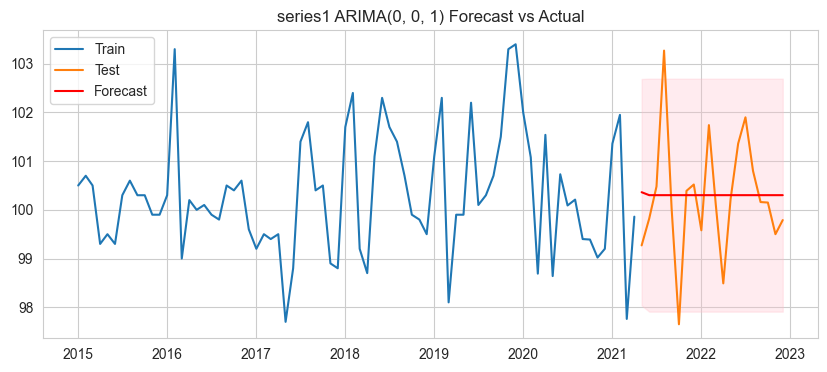


series3 ARIMA(4, 0, 5) Forecast RMSE: 1.6945, MAE: 1.3102


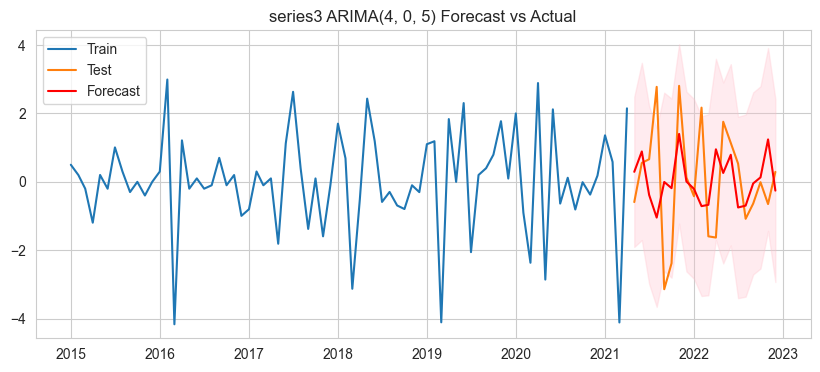

In [31]:
forecast_results = {}
for key, info in best_models.items():
    order = info['order']
    s = series_dict[key].dropna()
    n = len(s)
    split = int(n * 0.8)  # 80/20
    train = s.iloc[:split]
    test = s.iloc[split:]
    # fit on train
    try:
        model_tr = ARIMA(train, order=order)
        res_tr = model_tr.fit()
    except Exception as e:
        print(f"Error fitting ARIMA{order} on train for {key}: {e}")
        continue
    # forecast
    steps = len(test)
    fc = res_tr.get_forecast(steps=steps)
    fc_mean = fc.predicted_mean
    rmse = mean_squared_error(test, fc_mean, squared=False)
    mae = mean_absolute_error(test, fc_mean)
    print(f"\n{key} ARIMA{order} Forecast RMSE: {rmse:.4f}, MAE: {mae:.4f}")
    # plot
    plt.figure(figsize=(10,4))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(fc_mean.index, fc_mean, label='Forecast', color='red')
    plt.fill_between(fc.conf_int().index, fc.conf_int().iloc[:,0], fc.conf_int().iloc[:,1], color='pink', alpha=0.3)
    plt.title(f"{key} ARIMA{order} Forecast vs Actual")
    plt.legend(); plt.show()
    forecast_results[key] = {'model': res_tr, 'fc_mean': fc_mean, 'rmse': rmse, 'mae': mae}


## Machine learning in ARIMA forecasting

We will treat ARIMA parameter search like an ML hyperparameter tuning task:
- Split series into train / test (time-based).
- For many candidate (p,d,q) from Step 1.3, fit model on train and compute forecast on test.
- Evaluate RMSE on test; choose parameters with lowest RMSE.
This process is repeated for series1 and series3. (This is equivalent to "ML in ARIMA forecasting" described in the template.)


In [32]:
def arima_rmse_on_holdout(series, order, train_frac=0.8):
    s = series.dropna()
    n = len(s)
    split = int(n * train_frac)
    train = s.iloc[:split]
    test = s.iloc[split:]
    try:
        model = ARIMA(train, order=order)
        res = model.fit()
        fc = res.get_forecast(steps=len(test)).predicted_mean
        rmse = mean_squared_error(test, fc, squared=False)
        mae = mean_absolute_error(test, fc)
        return {'order': order, 'rmse': rmse, 'mae': mae, 'res': res, 'fc': fc}
    except Exception as e:
        return {'order': order, 'rmse': np.inf, 'mae': np.inf, 'error': str(e)}

ml_search_results = {}
for key, cfg in search_configs.items():
    s = series_dict[key]
    p_max = cfg['p_max']
    q_max = cfg['q_max']
    d_vals = cfg['d_vals']
    candidates = [(p,d,q) for d in d_vals for p in range(0,p_max+1) for q in range(0,q_max+1)]
    best = None
    print(f"\nML-style ARIMA RMSE search for {key}, candidates: {len(candidates)}")
    for order in candidates:
        out = arima_rmse_on_holdout(s, order)
        if best is None or out['rmse'] < best['rmse']:
            best = out
            # print progress
            print(f"New best {order} RMSE={out['rmse']:.4f}")
    ml_search_results[key] = best
    print(f"Best by RMSE for {key}: {best['order']} RMSE={best['rmse']:.4f}")



ML-style ARIMA RMSE search for series1, candidates: 90
New best (0, 0, 0) RMSE=1.1849
New best (0, 0, 2) RMSE=1.1849
New best (0, 0, 7) RMSE=1.0700
Best by RMSE for series1: (0, 0, 7) RMSE=1.0700

ML-style ARIMA RMSE search for series3, candidates: 156
New best (0, 0, 0) RMSE=1.5651
New best (0, 0, 5) RMSE=1.5603
New best (0, 0, 8) RMSE=1.4229
Best by RMSE for series3: (0, 0, 8) RMSE=1.4229


In [33]:
for key in series_dict.keys():
    aic_choice = best_models[key]['order']
    ml_choice = ml_search_results[key]['order']
    print(f"\n{key}: AIC-selected ARIMA{aic_choice} vs ML-selected ARIMA{ml_choice}")
    print(f"  - AIC-selected RMSE (on holdout): {forecast_results[key]['rmse'] if key in forecast_results else 'N/A'}")
    print(f"  - ML-selected RMSE: {ml_search_results[key]['rmse']:.4f}")



series1: AIC-selected ARIMA(0, 0, 1) vs ML-selected ARIMA(0, 0, 7)
  - AIC-selected RMSE (on holdout): 1.1876510829103684
  - ML-selected RMSE: 1.0700

series3: AIC-selected ARIMA(4, 0, 5) vs ML-selected ARIMA(0, 0, 8)
  - AIC-selected RMSE (on holdout): 1.6945398693634872
  - ML-selected RMSE: 1.4229


## SARIMA modelling & seasonal parameter search (m = 12)

Procedure:
- Use best non-seasonal (pO,dO,qO) as base.
- For P in [0..Pmax], Q in [0..Qmax], fix D=0 (as template suggests) and m=12.
- Fit SARIMAX on train and compute RMSE on test.
- Choose P,Q with lowest RMSE.


In [34]:
def sarima_seasonal_search(series, base_order, P_range=(0,1), Q_range=(0,1), D=0, m=12, train_frac=0.8):
    s = series.dropna()
    n = len(s)
    split = int(n * train_frac)
    train = s.iloc[:split]
    test = s.iloc[split:]
    best = None
    results = []
    for P in range(P_range[0], P_range[1]+1):
        for Q in range(Q_range[0], Q_range[1]+1):
            seasonal_order = (P, D, Q, m)
            try:
                mod = SARIMAX(train, order=base_order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
                res = mod.fit(disp=False)
                fc = res.get_forecast(steps=len(test)).predicted_mean
                rmse = mean_squared_error(test, fc, squared=False)
                results.append({'seasonal_order': seasonal_order, 'rmse': rmse, 'res': res})
                if best is None or rmse < best['rmse']:
                    best = {'seasonal_order': seasonal_order, 'rmse': rmse, 'res': res, 'fc': fc}
                    print(f"New best seasonal {seasonal_order} RMSE={rmse:.4f}")
            except Exception as e:
                # skip failing combos
                continue
    return best, pd.DataFrame(results)

sarima_results = {}
for key in series_dict.keys():
    base = best_models[key]['order']  # base pO,dO,qO from AIC selection
    print(f"\nSARIMA seasonal search for {key}, base order {base}")
    best_seasonal, df_res = sarima_seasonal_search(series_dict[key], base_order=base, P_range=(0,2), Q_range=(0,2), D=0, m=12)
    if best_seasonal:
        print(f"Best seasonal for {key}: {best_seasonal['seasonal_order']} RMSE={best_seasonal['rmse']:.4f}")
    else:
        print("No SARIMA seasonal model fitted successfully.")
    sarima_results[key] = {'best': best_seasonal, 'all': df_res}



SARIMA seasonal search for series1, base order (0, 0, 1)
New best seasonal (0, 0, 0, 12) RMSE=98.1546
New best seasonal (0, 0, 1, 12) RMSE=73.1351
New best seasonal (1, 0, 0, 12) RMSE=1.4726
New best seasonal (1, 0, 1, 12) RMSE=1.1269
Best seasonal for series1: (1, 0, 1, 12) RMSE=1.1269

SARIMA seasonal search for series3, base order (4, 0, 5)
New best seasonal (0, 0, 0, 12) RMSE=1.5646
Best seasonal for series3: (0, 0, 0, 12) RMSE=1.5646



series1 comparison:
ARIMA(0, 0, 1) RMSE (AIC-fit): 1.1876510829103684
SARIMA seasonal order: (1, 0, 1, 12), RMSE: 1.1269


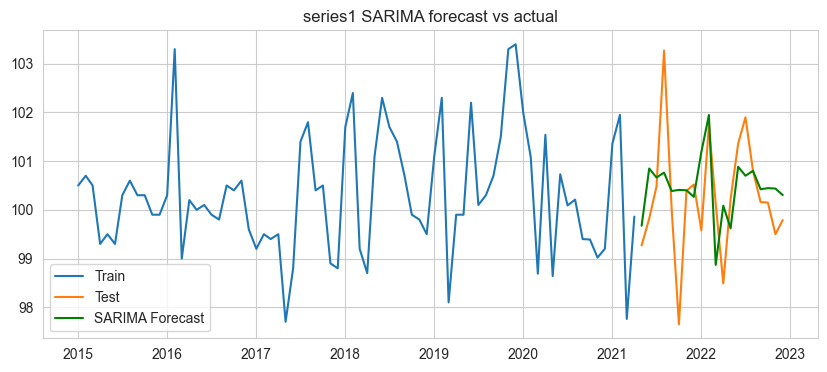


series3 comparison:
ARIMA(4, 0, 5) RMSE (AIC-fit): 1.6945398693634872
SARIMA seasonal order: (0, 0, 0, 12), RMSE: 1.5646


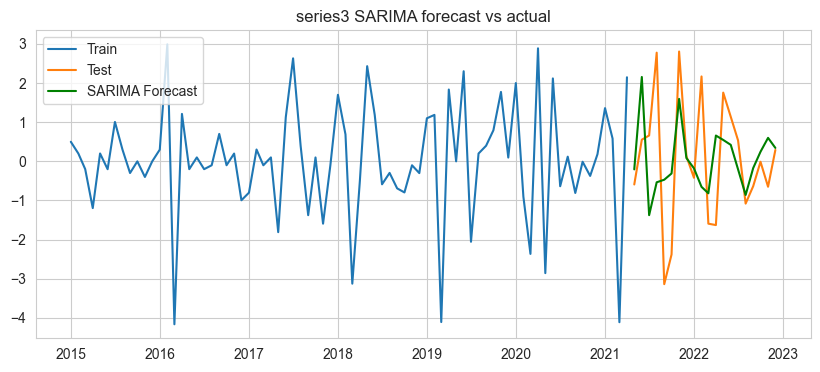

In [35]:
for key in series_dict.keys():
    print("\n" + "="*50)
    print(f"{key} comparison:")
    # ARIMA results
    ar_rmse = forecast_results.get(key, {}).get('rmse', np.nan)
    ar_order = best_models.get(key, {}).get('order')
    print(f"ARIMA{ar_order} RMSE (AIC-fit): {ar_rmse}")
    # SARIMA
    sar_best = sarima_results.get(key, {}).get('best')
    if sar_best:
        print(f"SARIMA seasonal order: {sar_best['seasonal_order']}, RMSE: {sar_best['rmse']:.4f}")
        # plot forecast vs test
        res_s = sar_best['res']
        # re-run forecast over the test period to get series aligned
        n = len(series_dict[key].dropna())
        split = int(n*0.8)
        test = series_dict[key].dropna().iloc[split:]
        fc = res_s.get_forecast(steps=len(test)).predicted_mean
        plt.figure(figsize=(10,4))
        plt.plot(series_dict[key].dropna().iloc[:split].index, series_dict[key].dropna().iloc[:split], label='Train')
        plt.plot(test.index, test, label='Test')
        plt.plot(fc.index, fc, label='SARIMA Forecast', color='green')
        plt.title(f"{key} SARIMA forecast vs actual")
        plt.legend(); plt.show()
    else:
        print("No SARIMA model available.")


## Part 1 — Conclusion (ARIMA & SARIMA)

- Present final selected models (for series 1 and series 3): AIC-selected, ML-selected (lowest RMSE), and best SARIMA (if exists).
- Show table summarizing: model order, AIC, BIC, RMSE (on holdout), MAE.
- Discuss:
  - If AIC-selected differs from RMSE-selected, which to prefer for forecasting purposes?
  - Whether parameter confidence intervals indicate stable/significant coefficients.
  - Residual diagnostics (plot ACF of residuals; run Ljung-Box) — if residuals show autocorrelation, model may be misspecified.


,series,AIC_order,AIC,AIC_RMSE_on_holdout,ML_order_by_RMSE,ML_RMSE,SARIMA_order,SARIMA_RMSE
0,series1,"(0, 0, 1)",310.462297,1.187651,"(0, 0, 7)",1.069951,"(1, 0, 1, 12)",1.126919
1,series3,"(4, 0, 5)",320.380176,1.694540,"(0, 0, 8)",1.422854,"(0, 0, 0, 12)",1.564643



Residual diagnostics for series1


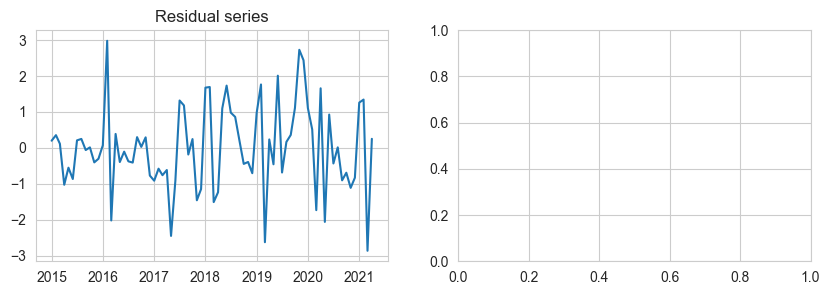

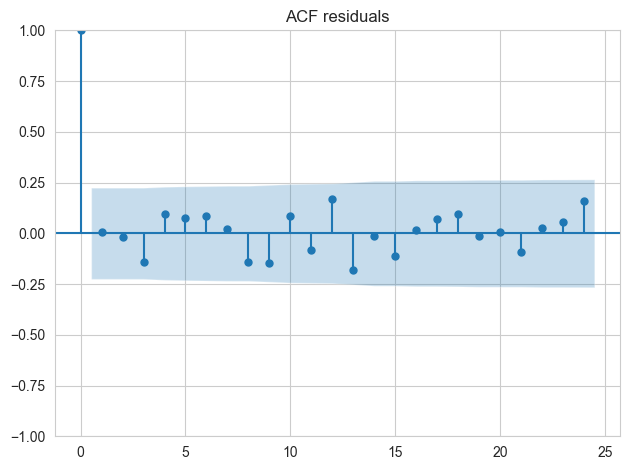

Ljung-Box p-value (lag 10): 0.6495101187546387

Residual diagnostics for series3


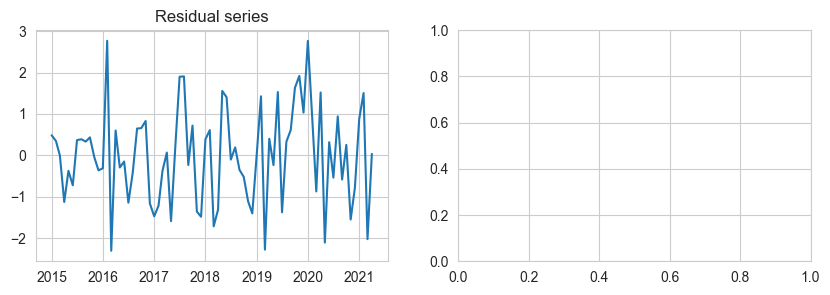

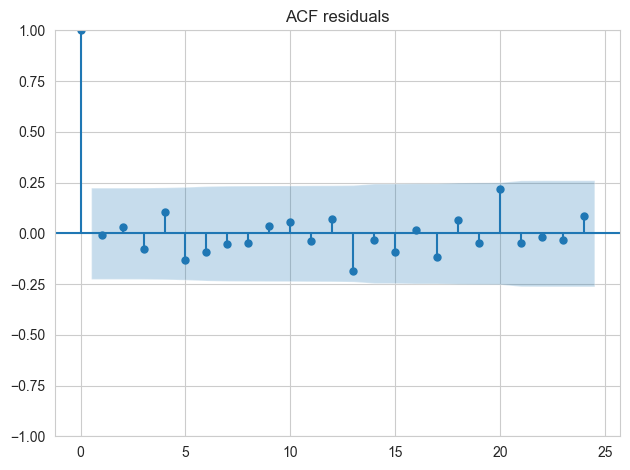

Ljung-Box p-value (lag 10): 0.9254926582555473


In [36]:
# Build summary table
rows = []
for key in series_dict.keys():
    aic_order = best_models[key]['order'] if key in best_models else None
    aic_val = best_models[key]['aic'] if key in best_models else None
    ml_order = ml_search_results[key]['order'] if key in ml_search_results else None
    ml_rmse = ml_search_results[key]['rmse'] if key in ml_search_results else None
    ar_rmse = forecast_results.get(key, {}).get('rmse', None)
    sar = sarima_results.get(key, {}).get('best')
    sar_order = sar['seasonal_order'] if sar else None
    sar_rmse = sar['rmse'] if sar else None
    rows.append({'series': key,
                 'AIC_order': aic_order, 'AIC': aic_val,
                 'AIC_RMSE_on_holdout': ar_rmse,
                 'ML_order_by_RMSE': ml_order, 'ML_RMSE': ml_rmse,
                 'SARIMA_order': sar_order, 'SARIMA_RMSE': sar_rmse})
summary_df = pd.DataFrame(rows)
display(summary_df)

# Residual diagnostics quick for selected ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

for key in series_dict.keys():
    resobj = forecast_results.get(key, {}).get('model')
    if resobj:
        resid = resobj.resid.dropna()
        print("\nResidual diagnostics for", key)
        plt.figure(figsize=(10,3))
        plt.subplot(1,2,1)
        plt.plot(resid); plt.title("Residual series")
        plt.subplot(1,2,2)
        plot_acf(resid, lags=24); plt.title("ACF residuals")
        plt.tight_layout(); plt.show()
        lb = acorr_ljungbox(resid, lags=[10], return_df=True)
        print("Ljung-Box p-value (lag 10):", lb['lb_pvalue'].iloc[0])
